In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 52.7 MB/s eta 0:00:00


In [ ]:
import os, random, re
from osgeo import gdal, osr
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import rasterio
from rasterio import plot
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import shape

In [ ]:
drive.mount('/content/drive')

# set the working directory
os.chdir('/content/drive/MyDrive/ProjectX')
print(f'Current working directory: {os.getcwd()}')

Mounted at /content/drive
Current working directory: /content/drive/.shortcut-targets-by-id/13WXSiVppKgfwKNMcFTNBVEPTVoVssMs8/ProjectX


In [ ]:
# listing of the current working directory
os.listdir(os.getcwd())

['.private-key.json',
 'Meeting minutes',
 'Reports',
 'Useful files',
 'Data',
 'ProjectX.ipynb',
 'Copy of ProjectX.ipynb',
 'yield_regressor_model.pkl']

In [ ]:
DATA_DIR = os.getcwd() + "/Data/"
DATA_DIR

'/content/drive/.shortcut-targets-by-id/13WXSiVppKgfwKNMcFTNBVEPTVoVssMs8/ProjectX/Data/'

In [ ]:
DATA_content = os.listdir(DATA_DIR)
DATA_content

['rwanda_boundary.geojson',
 'LandsatSurfaceReflectanceRutsiro.tif',
 'LandsatSurfaceReflectanceImages',
 'NDVISurfaceReflectance',
 'RwandaDistricts.zip',
 '.ipynb_checkpoints',
 'GlobalLandcover',
 'rwanda_locations_maize.csv',
 'rwanda_locations_potato.csv',
 'maize_df_features.csv']

In [ ]:
def extract_name_from_path(img_path, _type="name"):
    """Given a filename, extract the name of the image"""

    if _type == "name":
        pattern = r'.*/(.*)\.tif'
        match = re.search(pattern, img_path)

        if match:
            return match.group(1)
    else:
        pattern = r'(\d+)\.tif'
        match = re.search(pattern, img_path)

        if match:
            return match.group(1)

## Africa Land Cover

In [ ]:
def plot_raster_img(img_path):
    """
        Function reads and plots a subset of the raster image
            - The images are big and heavy to render at once
            - Plotting a subset is more memory efficient
    """
    img_name = extract_name_from_path(img_path)
    with rasterio.open(img_path) as src:
        w = rasterio.windows.Window(0, 0, 1024*20, 1024*20)  # xoff, yoff, xsize, ysize
        subset = src.read(1, window=w)
        plt.imshow(subset)
        plt.title(img_name)
        plt.show()

In [ ]:
land_cover_dir = DATA_DIR + "GlobalLandcover/"
land_cover_dir

'/content/drive/.shortcut-targets-by-id/13WXSiVppKgfwKNMcFTNBVEPTVoVssMs8/ProjectX/Data/GlobalLandcover/'

In [ ]:
os.listdir(land_cover_dir)

['2020.Map.tif',
 'African_land_cover.tif',
 'L1_LCC_22.tif',
 'L1_LCC_20.tif',
 'L1_LCC_19.tif',
 'L1_LCC_16.tif',
 'Clipped_Rwanda_L1_LCC_19.tif',
 'Clipped_Rutsiro_L1_LCC_19.tif',
 'Clipped_Rwanda_L1_LCC_16.tif',
 'Clipped_Rutsiro_L1_LCC_16.tif',
 'Clipped_Rwanda_L1_LCC_20.tif',
 'Clipped_Rutsiro_L1_LCC_20.tif']

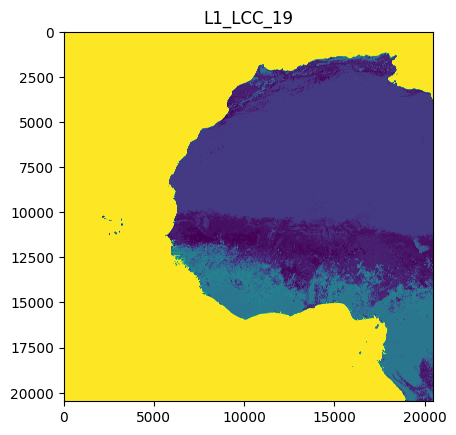

In [ ]:
land_cover_images = ['L1_LCC_19.tif', 'L1_LCC_16.tif', 'L1_LCC_20.tif']
random_land_cover = random.choice(land_cover_images)
random_img_path = land_cover_dir + "/" + random_land_cover
plot_raster_img(random_img_path)

### Geo-referencing and clipping

In [ ]:
DATA_DIR

'/content/drive/.shortcut-targets-by-id/13WXSiVppKgfwKNMcFTNBVEPTVoVssMs8/ProjectX/Data/'

In [ ]:
country_roi_path = DATA_DIR + "rwanda_boundary.geojson"

# Load the ROI GeoJSON file
country_roi = gpd.read_file(country_roi_path)

In [ ]:
def geo_reference_fn(img_path, roi, visualize=False):
    """
        Given a raster image and roi, can we check if these two objects relate geometrically and also intersect
            -  Ensure that the CRS matches, do this explicitly even if the roi has the same CRS as the raster
            - Show the bounds of the raster and ROI
            - Provide an image for the intersection if requested
    """
    # Check CRS of the raster file
    with rasterio.open(img_path) as src:
        print("Raster Image CRS:", src.crs)

    # Even if geo-reference is done
    # be safe and do the same to the roi
    # Set the CRS of the GeoDataFrame to match the raster
    roi.set_crs(epsg=4326, inplace=True)

    # Check CRS of the GeoJSON file
    print("roi GeoJSON CRS:", roi.crs)

    """Check intersection"""
    print("*"*20)
    # Check bounds of the GeoJSON file
    print("GeoJSON bounds:", roi.total_bounds)

    # Check bounds of the raster file
    with rasterio.open(img_path) as src:
        print("Raster bounds:", src.bounds)

    if visualize:
        print("*"*20)
        # Plot raster
        with rasterio.open(img_path) as src:
            fig, ax = plt.subplots()
            rasterio.plot.show(src, ax=ax)

        # Plot ROI
        roi.boundary.plot(ax=ax, color="red")
        plt.show()

Raster Image CRS: EPSG:4326
roi GeoJSON CRS: EPSG:4326
********************
GeoJSON bounds: [28.86175401 -2.83993835 30.89911796 -1.04737531]
Raster bounds: BoundingBox(left=-30.0044643, bottom=-40.004464373840015, right=65.00446439304002, top=40.0044643)
********************


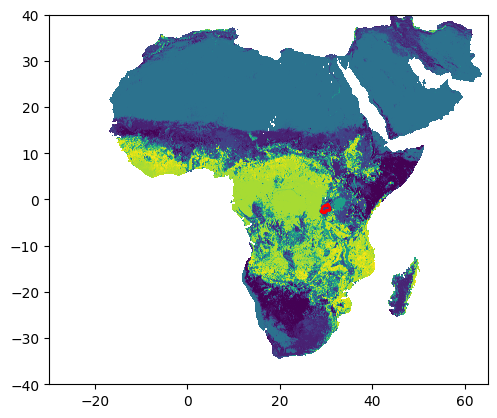

In [ ]:
geo_reference_fn(random_img_path, country_roi, True)

In [ ]:
def clip_country(img_path, roi, visualize=False):
    # Use full geometry
    geometry = roi['geometry'].unary_union

    # Load the Global Land Cover map
    with rasterio.open(img_path) as src:
        # Clip the raster
        out_image, out_transform = mask(src, [geometry.__geo_interface__], crop=True)

        # Update metadata
        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff",
                        "height": out_image.shape[1],
                        "width": out_image.shape[2],
                        "transform": out_transform})

        img_name = extract_name_from_path(img_path)
        new_img = land_cover_dir + "/" + f'Clipped_Rwanda_{img_name}.tif'
        # Save the clipped raster
        with rasterio.open(new_img, 'w', **out_meta) as dest:
            dest.write(out_image)

        if visualize:
            with rasterio.open(new_img) as src:
                plot.show(src)

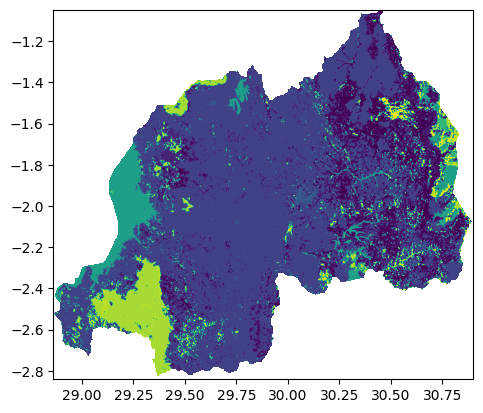

In [ ]:
clip_country(random_img_path, country_roi, True)

### Clip district

In [ ]:
district_shape_file = DATA_DIR + "RwandaDistricts.zip"
district_shape_file

'/content/drive/.shortcut-targets-by-id/13WXSiVppKgfwKNMcFTNBVEPTVoVssMs8/ProjectX/Data/RwandaDistricts.zip'

In [ ]:
# Read the shape file and get the geometry for the
# district of interest
def defineROI(district_name, gdf):
    area = None
    for _, row in gdf.iterrows():
        if row['NAME_2'] == district_name:
            area = shape(row['geometry'])
    return area

district = "Rutsiro"

In [ ]:
def clip_district(country_map_path, district, visualize=False):
    """
        From the country map generated and the new roi, clip the region of choice
            - 1st show the roi then clip it
    """
    # Read the shapefile; source-https://geodata.lib.utexas.edu/catalog/stanford-jg878ms7026
    gdf = gpd.read_file(district_shape_file)
    roi = defineROI(district, gdf)

    # plot the raster
    if visualize:
        roi_series = gpd.GeoSeries([roi]) # Convert the Shapely geometry obj to a GeoSeries
        with rasterio.open(country_map_path) as src:
            fig, ax = plt.subplots()
            rasterio.plot.show(src, ax=ax)

        # plot ROI
        roi_series.boundary.plot(ax=ax, color="red")
        plt.show()

    print("*"*20)
    print(f"Clipped {district} image")
    # Convert to GeoJSON
    roi_geojson = roi.__geo_interface__

    # Load the Rwanda Land Cover raster
    with rasterio.open(country_map_path) as src:

        # Clip the raster using the ROI
        out_image, out_transform = mask(src, [roi_geojson], crop=True)

        # Update metadata
        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff",
                        "height": out_image.shape[1],
                        "width": out_image.shape[2],
                        "transform": out_transform})

        # Save the clipped raster
        img_yr = extract_name_from_path(country_map_path, "number")
        new_img = land_cover_dir + f'Clipped_{district}_L1_LCC_{img_yr}.tif'
        with rasterio.open(new_img, 'w', **out_meta) as dest:
            dest.write(out_image)

        if visualize:
            with rasterio.open(new_img) as src:
                plot.show(src)

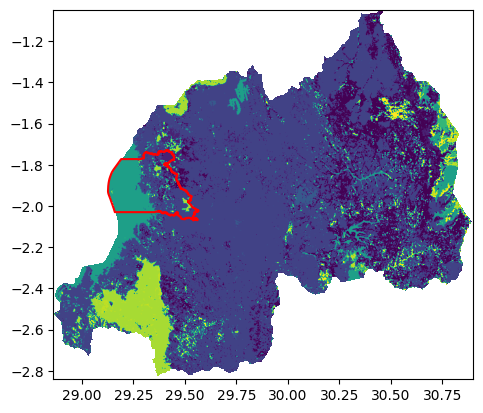

********************
Clipped Rutsiro image


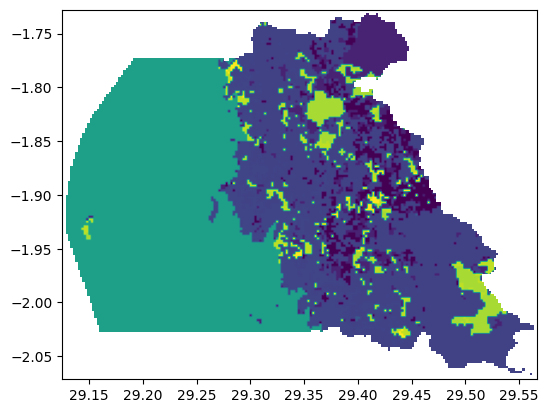

In [ ]:
clip_district(land_cover_dir + "Clipped_Rwanda_L1_LCC_19.tif", district, True)

### Process images for 2016,19,20

**************************************************
Processing 2019 image


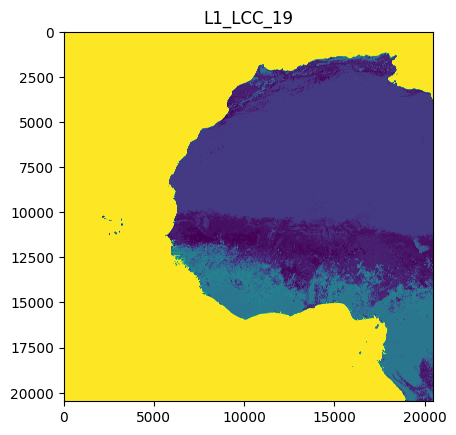

Raster Image CRS: EPSG:4326
roi GeoJSON CRS: EPSG:4326
********************
GeoJSON bounds: [28.86175401 -2.83993835 30.89911796 -1.04737531]
Raster bounds: BoundingBox(left=-30.0044643, bottom=-40.004464373840015, right=65.00446439304002, top=40.0044643)
********************


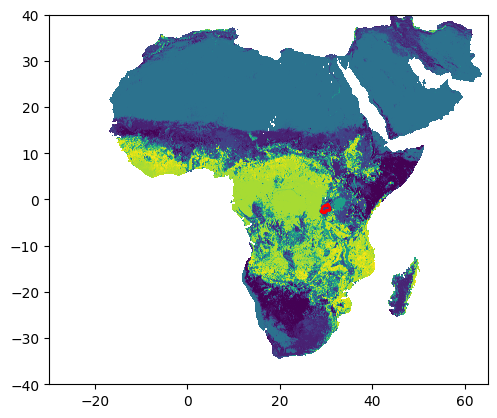

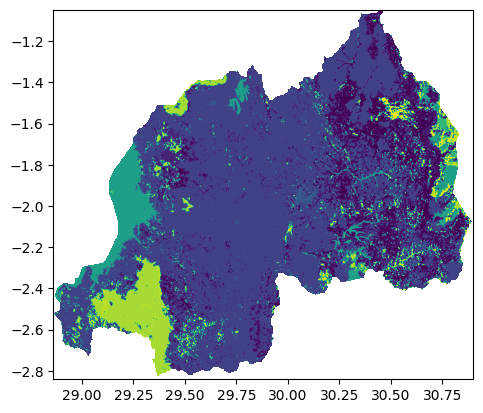

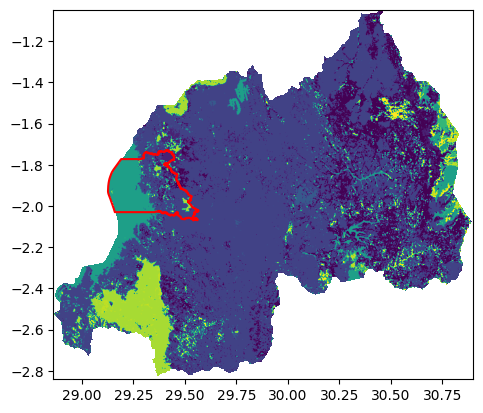

********************
Clipped Rutsiro image


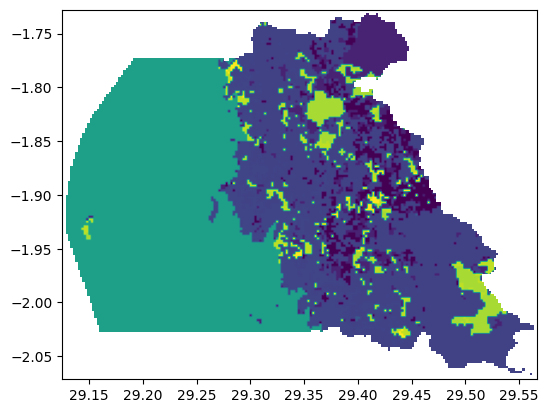

**************************************************
Processing 2016 image


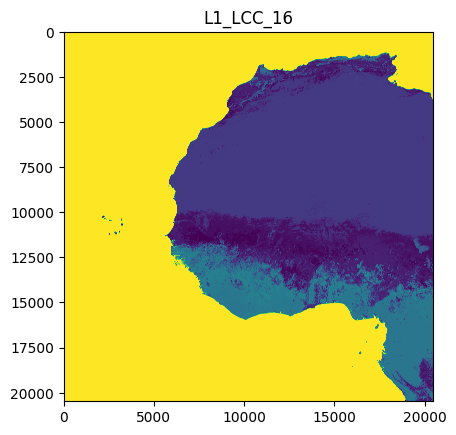

Raster Image CRS: EPSG:4326
roi GeoJSON CRS: EPSG:4326
********************
GeoJSON bounds: [28.86175401 -2.83993835 30.89911796 -1.04737531]
Raster bounds: BoundingBox(left=-30.0044643, bottom=-40.004464373840015, right=65.00446439304002, top=40.0044643)
********************


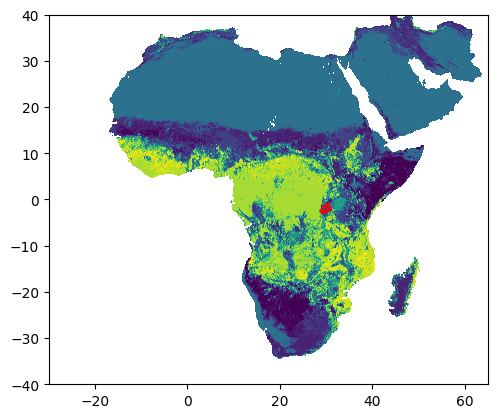

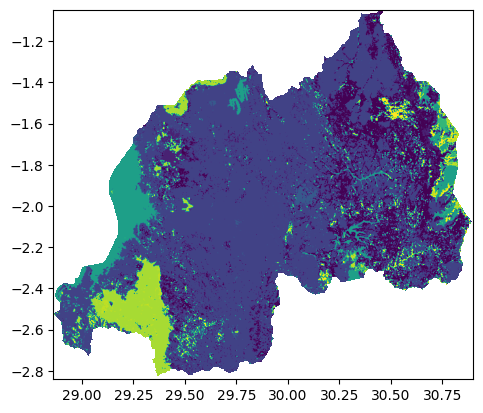

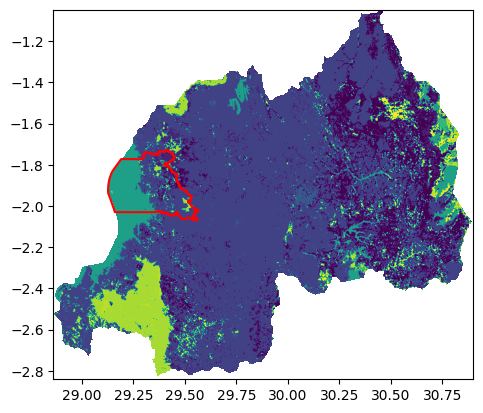

********************
Clipped Rutsiro image


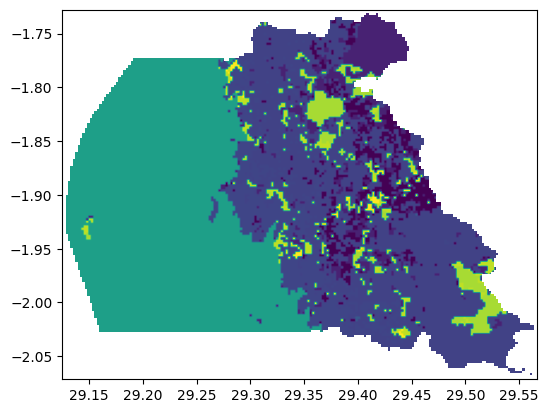

**************************************************
Processing 2020 image


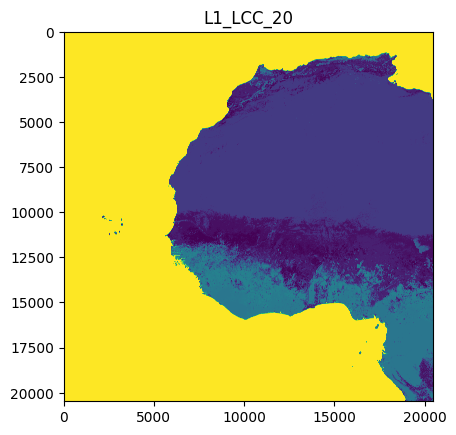

Raster Image CRS: EPSG:4326
roi GeoJSON CRS: EPSG:4326
********************
GeoJSON bounds: [28.86175401 -2.83993835 30.89911796 -1.04737531]
Raster bounds: BoundingBox(left=-30.0044643, bottom=-40.004464373840015, right=65.00446439304002, top=40.0044643)
********************


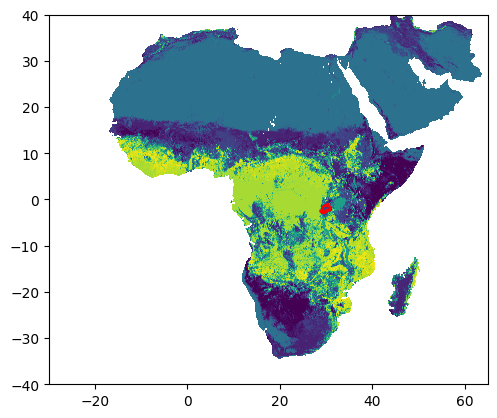

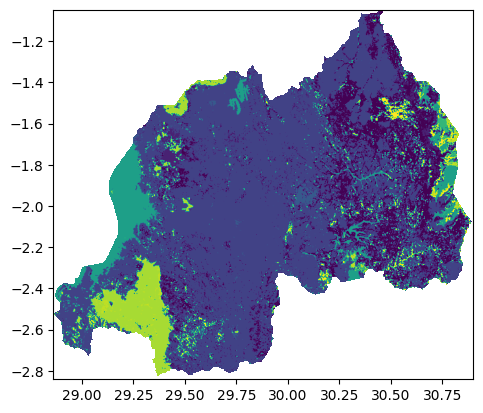

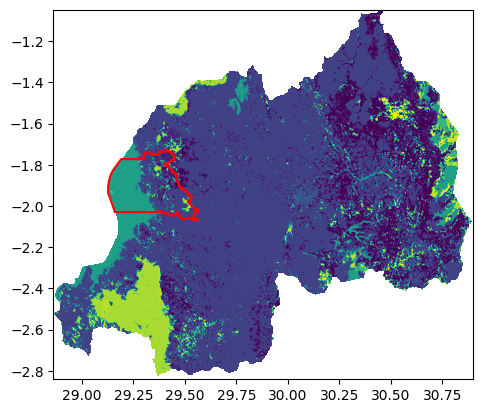

********************
Clipped Rutsiro image


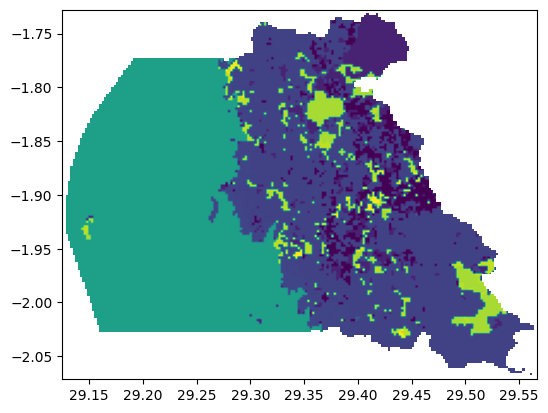

In [ ]:
for raster_image in land_cover_images:
    raster_image_path = land_cover_dir + "/" + raster_image
    img_yr = extract_name_from_path(raster_image_path, "number")
    country_image_path = land_cover_dir + f"Clipped_Rwanda_L1_LCC_{img_yr}.tif"

    print("*"*50)
    print(f"Processing 20{img_yr} image")

    # plot the raster - Optionally
    plot_raster_img(raster_image_path)
    # Geo-reference the image
    geo_reference_fn(raster_image_path, country_roi, True)
    # Clip country
    clip_country(raster_image_path, country_roi, True)
    # Clip district
    clip_district(country_image_path, district, True)

### Load and extract fields of interest

#### Maize locations

In [ ]:
import pandas as pd

In [ ]:
maize_locs_pd = pd.read_csv(DATA_DIR + "rwanda_locations_maize.csv")
maize_locs_pd

,Unnamed: 0,unique_id,district,site,chickens,cows,pigs,bikes,goats,sheep,...,slope_angle_des,seed_depth_est,harvest_date,plant_date,hybridseed_kg,stalk_rot,kelnel_rot,sitename,site_longitude,site_latitude
0,29571,b16e2559,Rutsiro,nganzoA,8.0,1.0,0.0,0.0,0.0,4.0,...,NaN,NaN,2016-03-03,2015-09-11,NaN,NaN,NaN,NaN,29.300162,-1.795746
1,29577,d1bb83da,Kibogora,Cyimpindu A,2.0,0.0,1.0,0.0,1.0,0.0,...,NaN,NaN,2016-02-15,2015-09-20,NaN,NaN,NaN,NaN,29.227296,-2.278404
2,29581,acb2142a,Nyamasheke,Buvungira B,2.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,2016-01-25,2015-09-22,NaN,NaN,NaN,NaN,29.107864,-2.455110
3,29589,13fc191f,Rubengera,MUBUGA R,0.0,2.0,1.0,0.0,0.0,0.0,...,NaN,NaN,2016-03-05,2015-09-14,NaN,NaN,NaN,NaN,29.507082,-2.093928
4,29598,ccad678e,Nyanza,Nyamure,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,2016-01-25,2015-09-18,NaN,NaN,NaN,NaN,29.810915,-2.356720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,52897,7f11df7e,Rwamagana,_Nyamirama,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2020-07-15,2020-02-27,NaN,NaN,NaN,NaN,30.349180,-1.639077
825,52899,ea74fe62,Rwamagana,_Nyamirama,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2020-07-20,2020-04-02,NaN,NaN,NaN,NaN,30.349180,-1.639077
826,52901,d33b721a,Rwamagana,_Nyamirama,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,2020-07-20,2020-02-25,NaN,NaN,NaN,NaN,30.349180,-1.639077
827,52905,5a1b3572,Rwamagana,_Ruhimbi,3.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,2020-06-30,2020-02-25,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
maize_locs_pd['year'].unique()

array([2016, 2019, 2020])

In [ ]:
for year in maize_locs_pd['year'].unique():
    # For each year load the image corresponding to that year
    # and plot out the fields containing maize, finally blackout anything
    # else that is not maize plantation

    yr = str(year)[-2:]
    pass

In [ ]:
os.listdir(DATA_DIR + "GlobalLandcover")

['2020.Map.tif',
 'African_land_cover.tif',
 'L1_LCC_22.tif',
 'L1_LCC_20.tif',
 'L1_LCC_19.tif',
 'L1_LCC_16.tif',
 'Clipped_Rwanda_L1_LCC_19.tif',
 'Clipped_Rutsiro_L1_LCC_19.tif',
 'Clipped_Rwanda_L1_LCC_16.tif',
 'Clipped_Rutsiro_L1_LCC_16.tif',
 'Clipped_Rwanda_L1_LCC_20.tif',
 'Clipped_Rutsiro_L1_LCC_20.tif']

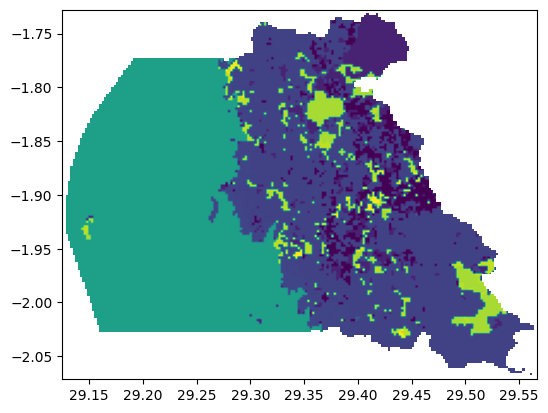

In [ ]:
with rasterio.open(DATA_DIR + f"GlobalLandcover/Clipped_Rutsiro_L1_LCC_{yr}.tif") as src:
    plot.show(src)

Raster CRS: EPSG:4326


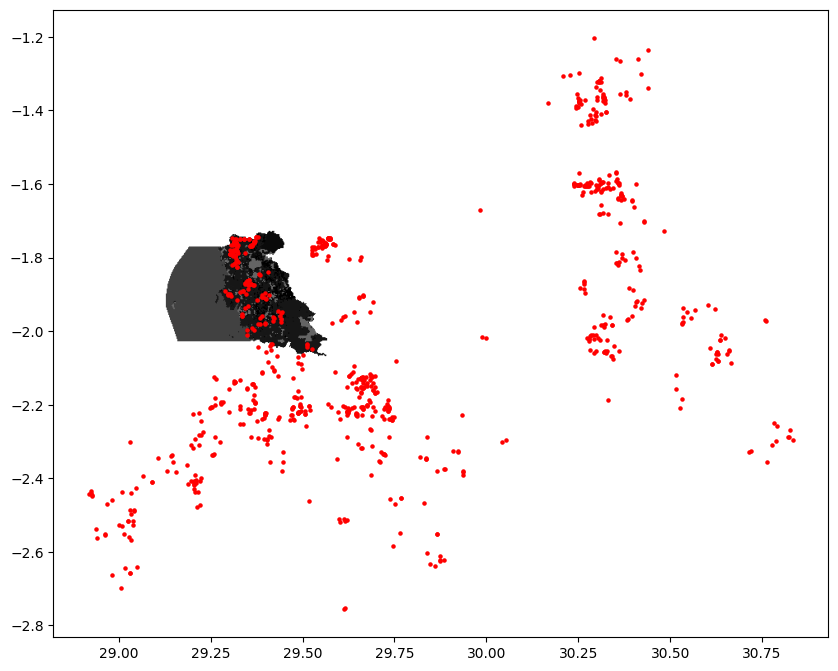

In [ ]:
# Step 1: Load the base map
with rasterio.open(DATA_DIR + f"GlobalLandcover/Clipped_Rutsiro_L1_LCC_{yr}.tif") as src:
    raster_crs = src.crs
    print(f"Raster CRS: {raster_crs}")

    # Read the raster data
    base_map_array = src.read(1)

    # Get the transform (assuming it's correct in the metadata)
    transform = src.transform

# Step 2: Create a GeoDataFrame from DataFrame with plots of interest
gdf = gpd.GeoDataFrame(
    maize_locs_pd,
    geometry=gpd.points_from_xy(
        maize_locs_pd.field_longitude, maize_locs_pd.field_latitude
    )
)

# Set the CRS for the GeoDataFrame to match the raster CRS
gdf.crs = raster_crs

# If necessary, convert the GeoDataFrame to the same CRS as the raster
if gdf.crs != raster_crs:
    gdf = gdf.to_crs(raster_crs)

# Step 3: Plot the base map and overlay the points
fig, ax = plt.subplots(figsize=(10, 10))
rasterio.plot.show(base_map_array, ax=ax, transform=transform, cmap='gray', extent=src.bounds)

# Overlay the plot points
gdf.plot(ax=ax, color='red', markersize=5)

plt.show()

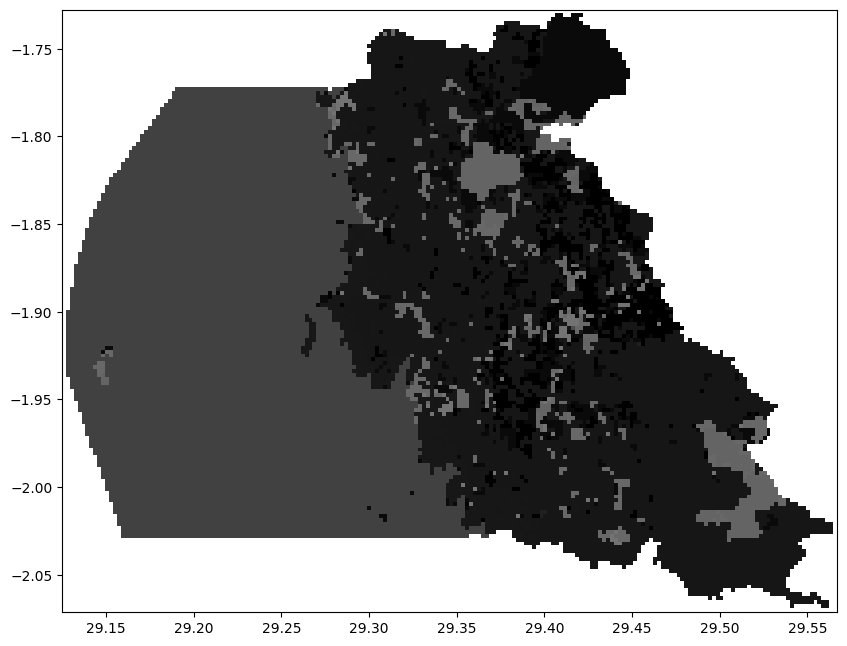

In [ ]:
import matplotlib.patches as mpatches
import rasterio.plot

# Read raster
with rasterio.open(DATA_DIR + f"GlobalLandcover/Clipped_Rutsiro_L1_LCC_{yr}.tif") as src:
    base_map_array = src.read(1)
    transform = src.transform

# Prepare the plot points and hectares
plot_points_hectares = [(row['field_longitude'], row['field_latitude'], row['plot_hectares']) for idx, row in maize_locs_pd.iterrows()]

# Function to create a rectangle from the center point and hectares
def hectares_to_edges(lon, lat, hectares):
    # Convert hectares to square meters
    area_sqm = hectares * 10000

    # Assume square plot to simplify, calculate the side length in meters
    side_length = np.sqrt(area_sqm)

    # Approximate conversion from meters to decimal degrees
    delta_deg = side_length / (111.32 * 1000)  # rough estimate: 111.32 km per degree
    return [(lon - delta_deg, lat - delta_deg), (lon + delta_deg, lat + delta_deg)]

# Convert to pixel coordinates and create rectangles
for point in plot_points_hectares:
    lon, lat, hectares = point
    bottom_left, top_right = hectares_to_edges(lon, lat, hectares)
    bottom_left_pixel = ~transform * bottom_left
    top_right_pixel = ~transform * top_right
    width = top_right_pixel[0] - bottom_left_pixel[0]
    height = top_right_pixel[1] - bottom_left_pixel[1]
    rect = mpatches.Rectangle(bottom_left_pixel, width, height, fill=False, edgecolor='red', linewidth=2)

    # Plot the rectangles on the map
    ax.add_patch(rect)

# Plot raster
fig, ax = plt.subplots(figsize=(10, 10))
rasterio.plot.show(base_map_array, ax=ax, transform=transform, cmap='gray', extent=src.bounds)

# Overlay the plot points
# gdf.plot(ax=ax, color='red', markersize=5)

plt.show()

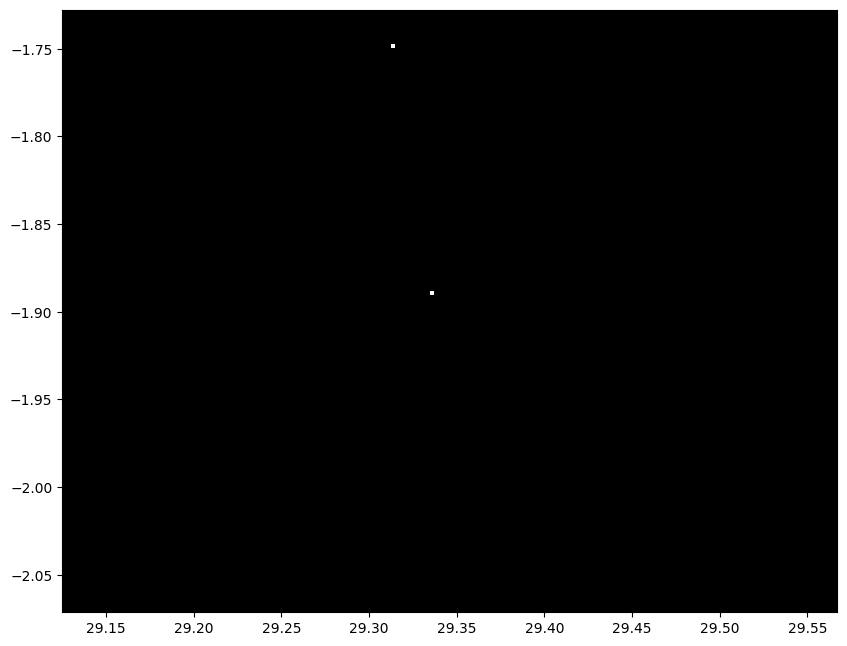

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import rasterio
import rasterio.plot

# Read raster
with rasterio.open(DATA_DIR + f"GlobalLandcover/Clipped_Rutsiro_L1_LCC_{yr}.tif") as src:
    base_map_array = src.read(1)
    transform = src.transform
    # Create a mask with the same dimensions as the base map, initialized to False
    mask = np.zeros(base_map_array.shape, dtype=bool)

# Prepare the plot points and hectares
plot_points_hectares = [(row['field_longitude'], row['field_latitude'], row['plot_hectares']) for idx, row in maize_locs_pd.iterrows()]

# Function to create a rectangle from the center point and hectares
def hectares_to_edges(lon, lat, hectares):
    # Convert hectares to square meters
    area_sqm = hectares * 10000
    # Assume square plot to simplify, calculate the side length in meters
    side_length = np.sqrt(area_sqm)
    # Approximate conversion from meters to decimal degrees
    delta_deg = side_length / (111.32 * 1000)  # rough estimate: 111.32 km per degree
    return [(lon - delta_deg, lat - delta_deg), (lon + delta_deg, lat + delta_deg)]

# Convert to pixel coordinates and create rectangles
for point in plot_points_hectares:
    lon, lat, hectares = point
    bottom_left, top_right = hectares_to_edges(lon, lat, hectares)
    bottom_left_pixel = ~transform * bottom_left
    top_right_pixel = ~transform * top_right
    # Calculate the bounding box in pixel coordinates
    left, bottom = map(int, ~transform * bottom_left)
    right, top = map(int, ~transform * top_right)
    # Update the mask to True within this bounding box
    mask[top:bottom, left:right] = True

# Update the base map array, setting the masked out areas to a no-data value
base_map_array[~mask] = base_map_array.min()  # or any other no-data value you prefer

# Plot raster
fig, ax = plt.subplots(figsize=(10, 10))
rasterio.plot.show(base_map_array, ax=ax, transform=transform, cmap='gray', extent=src.bounds)

# Add rectangles for visual reference (optional, since the mask already shows the plots)
for point in plot_points_hectares:
    lon, lat, hectares = point
    bottom_left, top_right = hectares_to_edges(lon, lat, hectares)
    bottom_left_pixel = ~transform * bottom_left
    top_right_pixel = ~transform * top_right
    width = top_right_pixel[0] - bottom_left_pixel[0]
    height = top_right_pixel[1] - bottom_left_pixel[1]
    rect = mpatches.Rectangle(bottom_left_pixel, width, height, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

plt.show()

In [ ]:
import rasterio
from rasterio.windows import Window

# Define the function to convert hectares to a window of pixels
def get_window_from_hectares(px, py, hectares, transform):
    # Convert hectares to square meters
    area_sqm = hectares * 10000

    # Calculate the pixel dimensions of the plot
    # The transform affine matrix contains the pixel width (transform[0]) and height (-transform[4])
    # (assuming north-up images, no rotation)
    pixel_size_x = transform[0]  # size of one pixel in the x-direction (width)
    pixel_size_y = -transform[4]  # size of one pixel in the y-direction (height)

    # Calculate the number of pixels for the plot dimensions
    num_pixels_x = int(np.sqrt(area_sqm) / pixel_size_x)
    num_pixels_y = int(np.sqrt(area_sqm) / pixel_size_y)

    # Define a window of pixels around the central point
    window = Window(px - num_pixels_x // 2, py - num_pixels_y // 2, num_pixels_x, num_pixels_y)
    return window

In [ ]:
plot_points = [(row['field_longitude'], row['field_latitude'], row['plot_hectares']) for idx, row in maize_locs_pd.iterrows()]


# Extract raster indices for specific points
with rasterio.open(DATA_DIR + f"GlobalLandcover/Clipped_Rutsiro_L1_LCC_{yr}.tif") as src:
    transform = src.transform

    count = 0
    for index, row in maize_locs_pd.iterrows():
        # Convert geographic coordinates to pixel coordinates
        px, py = ~transform * (row['field_longitude'], row['field_latitude'])
        px, py = int(px), int(py)

        # Get the window of pixels for the plot
        window = get_window_from_hectares(px, py, row['plot_hectares'], transform)


        # Extract raster value
        if (px >= 0 and px < src.width) and (py >= 0 and py < src.height):
            raster_value = src.read(1, window=window)  # Read the value from the raster
            count += 1

            # Do something with the raster value
            # print(px, py, row['field_latitude'], window)
    print(count)

198


---

In [ ]:
import geopandas as gpd
from shapely.geometry import Polygon
def hectares_to_square_edges(lon, lat, hectares):
    """
    This function takes the center point (lon, lat) of a plot and the size in hectares,
    and returns the coordinates of the square edges.
    """
    # Convert hectares to square meters
    area_sqm = hectares * 10000
    # Assume square plot to simplify, calculate the side length in meters
    side_length_m = np.sqrt(area_sqm)
    # Convert side length from meters to degrees (approximation)
    side_length_deg = side_length_m / (111.32 * 1000)  # rough estimate: 111.32 km per degree

    # Calculate the coordinates of the four corners of the square
    top_left = (lon - side_length_deg, lat + side_length_deg)
    top_right = (lon + side_length_deg, lat + side_length_deg)
    bottom_left = (lon - side_length_deg, lat - side_length_deg)
    bottom_right = (lon + side_length_deg, lat - side_length_deg)

    return [top_left, top_right, bottom_right, bottom_left, top_left]  # Closed loop

# Example usage
for index, row in maize_locs_pd.iterrows():
    # Get the center point of the plot
    lon, lat = row['field_longitude'], row['field_latitude']

    # Get the coordinates of the square edges
    square_edges = hectares_to_square_edges(lon, lat, row['plot_hectares'])
    print(f"Square edges for plot {index}: {square_edges}")

    if index == 5:
        break

# Apply the function to each row in the dataframe to create a polygon for each plot
maize_locs_pd['geometry'] = maize_locs_pd.apply(
    lambda row: Polygon(hectares_to_square_edges(row['field_longitude'], row['field_latitude'], row['plot_hectares'])),
    axis=1
)

# Convert the dataframe to a GeoDataFrame
gdf = gpd.GeoDataFrame(maize_locs_pd, geometry='geometry', crs="EPSG:4326")

Square edges for plot 0: [(29.306679090654363, -1.7912547877359117), (29.307080846619037, -1.7912547877359117), (29.307080846619037, -1.7916565437005885), (29.306679090654363, -1.7916565437005885), (29.306679090654363, -1.7912547877359117)]
Square edges for plot 1: [(29.22219263068216, -2.2831519330865957), (29.222446723457445, -2.2831519330865957), (29.222446723457445, -2.2834060258618845), (29.22219263068216, -2.2834060258618845), (29.22219263068216, -2.2831519330865957)]
Square edges for plot 2: [(29.09005207244327, -2.4113177724252113), (29.090231743167728, -2.4113177724252113), (29.090231743167728, -2.4114974431496687), (29.09005207244327, -2.4114974431496687), (29.09005207244327, -2.4113177724252113)]
Square edges for plot 3: [(29.4875293582551, -2.0866684018304675), (29.4878134426221, -2.0866684018304675), (29.4878134426221, -2.086952486197472), (29.4875293582551, -2.086952486197472), (29.4875293582551, -2.0866684018304675)]
Square edges for plot 4: [(29.834848195942957, -2.3459

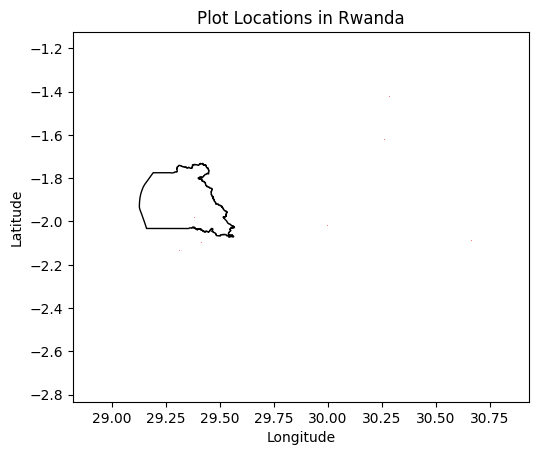

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming `maize_locs_pd` has a 'geometry' column with the polygon data
gdf = gpd.GeoDataFrame(maize_locs_pd, geometry='geometry', crs="EPSG:4326")

# Load a shapefile of Rwanda (or any other reference layer you have)
rwanda_boundary = gpd.read_file(district_shape_file)
# Ensure defineROI returns a GeoDataFrame
roi_gdf = gpd.GeoDataFrame([defineROI(district, rwanda_boundary)], columns=['geometry'], geometry='geometry', crs="EPSG:4326")

# Plot the reference layer
base = roi_gdf.plot(color='white', edgecolor='black')

# Overlay the plot polygons on top of the base layer
gdf.plot(ax=base, color='red', alpha=0.5)

# Add labels
plt.title('Plot Locations in Rwanda')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

## Agricultural indices extraction

### NDVI, EVI, SAVI & GNDVI Indices

In [ ]:
import ee
from datetime import datetime

In [ ]:
!earthengine authenticate

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=Zy2G539hFKn8qBrAtHI-55o1CVWm305RvwZBcnMbiHs&tc=yiHUSxqcV9n2WVg8PP071PVBpW9Q3aOQFWyoPQkRQGg&cc=J6n99CebuOMs1TB7wAEI3qWycS-xyXSafzvJR098aF8

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfJohXnA2bmbuET4cimTzotks56rzNt3zzO3hR5hVgv4uhw4fsTxxe2T5qs

Successfully saved authorization token.


In [ ]:
# Initialize the Earth Engine module.
ee.Initialize()

In [ ]:
def get_sentinel_images(aoi, start_date, end_date, cloud_probability_threshold):
    """
    Fetch Sentinel-2 images from Google Earth Engine for the given AOI and time range,
    with cloud masking based on a cloud probability threshold.

    Parameters:
    - aoi (ee.Geometry.Polygon): Area of interest as a Polygon.
    - start_date (str): Start date in the format 'YYYY-MM-DD'.
    - end_date (str): End date in the format 'YYYY-MM-DD'.
    - cloud_probability_threshold (float): Cloud probability threshold for masking.

    Returns:
    - Dictionary: Mean values of indices within the AOI.
    """
    # Load the Sentinel-2 ImageCollection and the cloud probability dataset.
    s2_collection = ee.ImageCollection('COPERNICUS/S2')
    cloud_probability_collection = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')

    # Filter the collections based on the AOI and the date range.
    filtered_s2_collection = s2_collection.filterDate(start_date, end_date).filterBounds(aoi)
    filtered_cloud_probability_collection = cloud_probability_collection.filterDate(start_date, end_date).filterBounds(aoi)

    def mask_clouds(s2_image):
        # Get the corresponding cloud probability image.
        cloud_probability_image = ee.Image(filtered_cloud_probability_collection.filterMetadata('system:index', 'equals', s2_image.get('system:index')).first())

        # Create a cloud mask where the cloud probability is less than the threshold.
        cloud_mask = cloud_probability_image.select('probability').lt(cloud_probability_threshold)

        # Apply the mask to the Sentinel-2 image.
        return s2_image.updateMask(cloud_mask)

    # Apply cloud masking to each image in the Sentinel-2 collection.
    masked_s2_collection = filtered_s2_collection.map(mask_clouds)

    # Define the add_indices function (remains the same as in your previous code)
    def add_indices(image):
        # NDVI
        ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')

        # EVI
        evi = image.expression(
            '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
            {
                'NIR': image.select('B8'),
                'RED': image.select('B4'),
                'BLUE': image.select('B2')
            }
        ).rename('EVI')

        # SAVI
        savi = image.expression(
            '(1 + L) * (NIR - RED) / (NIR + RED + L)',
            {
                'NIR': image.select('B8'),
                'RED': image.select('B4'),
                'L': 0.5
            }
        ).rename('SAVI')

        # GNDVI
        gndvi = image.normalizedDifference(['B8', 'B3']).rename('GNDVI')

        # Add the indices as new bands
        return image.addBands([ndvi, evi, savi, gndvi])

    # Map the add_indices function over the masked collection.
    indexed_collection = masked_s2_collection.map(add_indices)

    # Create a median composite from the indexed collection.
    median_composite = indexed_collection.median()

    # Calculate the mean values of the indices over the AOI using the median composite.
    mean_values = median_composite.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=10,  # Set the scale for Sentinel-2
        maxPixels=1e9
    ).getInfo()  # Call getInfo() here to retrieve the computed values

    # Initialize an empty dictionary to store index values
    indices_dict = {}

    # List of expected index names
    expected_indices = ['NDVI', 'EVI', 'SAVI', 'GNDVI']

    # Retrieve the mean value for each index and store it in the dictionary
    for index in expected_indices:
        if index in mean_values:
            indices_dict[index] = mean_values[index]
        else:
            # If the index is not found, print an error message
            print(f"Index {index} not found in the image. Available keys: {mean_values.keys()}")

    return indices_dict


In [ ]:
# Use this function to get the indices for a given AOI and date range
# Example usage:
aoi = ee.Geometry.Polygon([
    [
        [29.306679090654363, -1.7912547877359117],
        [29.307080846619037, -1.7912547877359117],
        [29.307080846619037, -1.7916565437005885],
        [29.306679090654363, -1.7916565437005885],
        [29.306679090654363, -1.7912547877359117]
    ]
])
start_date = '2016-11-30'
end_date = '2016-12-30'
indices = get_sentinel_images(aoi, start_date, end_date, 15)
print(indices)

{'NDVI': 0.06278899870812893, 'EVI': -0.4776610209571104, 'SAVI': 0.09416878851812557, 'GNDVI': 0.07057230733335018}


In [ ]:
# Todo: could be moved up
from datetime import datetime, timedelta

# Function to calculate start and end dates for satellite image collection
def calculate_satellite_dates(year, season, period_start, period_end):
    if season == 'a season':
        season_start = datetime(year, 9, 1)  # Start of A season is Early September
    elif season == 'b season':
        season_start = datetime(year, 2, 15)  # Start of B season is Mid-Late February
    else:
        raise ValueError("Invalid season. Season should be 'a season' or 'b season'.")

    # Satellite image collection starting and ending at the specified period
    # Indices will have different collection time periods
    start_date = season_start + timedelta(days=period_start)
    end_date = season_start + timedelta(days=period_end)

    return start_date, end_date

# Apply the function to each row in the dataframe
maize_locs_pd['start_date'], maize_locs_pd['end_date'] = zip(*maize_locs_pd.apply(lambda row: calculate_satellite_dates(row['year'], row['season'], 90, 120), axis=1))
maize_locs_pd.sample(5)

,Unnamed: 0,unique_id,district,site,chickens,cows,pigs,bikes,goats,sheep,...,plant_date,hybridseed_kg,stalk_rot,kelnel_rot,sitename,site_longitude,site_latitude,geometry,start_date,end_date
668,51710,6b059d53,Ngororero,_Gaseke,NaN,1.0,NaN,NaN,NaN,NaN,...,2020-03-04,NaN,NaN,NaN,NaN,29.004303,-2.565568,POLYGON ((29.551552570816913 -1.77145866250693...,2020-05-15,2020-06-14
275,40168,5bc5e2c5,Rubengera,MWENDO MA .,2.0,3.0,1.0,0.0,4.0,0.0,...,2015-09-06,NaN,NaN,NaN,NaN,29.527601,-2.029987,POLYGON ((29.511077415201342 -2.03805331390488...,2016-11-30,2016-12-30
351,40574,b7958f99,LWE,Nyamatete B,0.0,0.0,0.0,0.0,0.0,1.0,...,2015-10-08,NaN,NaN,NaN,NaN,30.465413,-1.582144,POLYGON ((30.321125115360456 -2.05727308528423...,2016-11-30,2016-12-30
538,49202,167313cd,Ngororero,NaN,6.0,1.0,0.0,NaN,2.0,0.0,...,2019-09-15,NaN,NaN,NaN,NaN,NaN,NaN,POLYGON ((29.62673613775864 -1.804219537758643...,2020-11-30,2020-12-30
41,29975,e233f177,Rutsiro,busuku,0.0,1.0,0.0,0.0,0.0,0.0,...,2015-09-10,NaN,NaN,NaN,NaN,29.409511,-1.751045,POLYGON ((29.377868808377812 -1.74408041823763...,2016-11-30,2016-12-30


### CSWI

In [ ]:
maize_locs_pd['start_date_cswi'], maize_locs_pd['end_date_cswi'] = zip(*maize_locs_pd.apply(lambda row: calculate_satellite_dates(row['year'], row['season'], 45, 85), axis=1))
maize_locs_pd.sample(5)

,Unnamed: 0,unique_id,district,site,chickens,cows,pigs,bikes,goats,sheep,...,stalk_rot,kelnel_rot,sitename,site_longitude,site_latitude,geometry,start_date,end_date,start_date_cswi,end_date_cswi
727,51980,28335756,Nyamasheke,_Gako A,NaN,NaN,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,29.129074,-2.366416,POLYGON ((29.1303909777615 -2.3795698641750893...,2020-05-15,2020-06-14,2020-03-31,2020-05-10
544,49405,4ab0c0ec,Rwamagana,NaN,0.0,0.0,0.0,NaN,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,POLYGON ((30.38844938060813 -1.883010708609168...,2020-11-30,2020-12-30,2020-10-16,2020-11-25
370,40716,0ecb6fdc,LWE,Mugera B,0.0,3.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,29.044649,-2.369913,POLYGON ((30.30306331566649 -1.610741226226439...,2016-11-30,2016-12-30,2016-10-16,2016-11-25
3,29589,13fc191f,Rubengera,MUBUGA R,0.0,2.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,29.507082,-2.093928,POLYGON ((29.4875293582551 -2.0866684018304675...,2016-11-30,2016-12-30,2016-10-16,2016-11-25
515,48684,80986d7b,Nyagatare,NaN,0.0,0.0,0.0,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,POLYGON ((30.325725520928124 -1.40453933683574...,2020-11-30,2020-12-30,2020-10-16,2020-11-25


In [ ]:
def calculate_lst(image):
    # Extract the thermal band (Band 10 for Landsat 8)
    thermal_band = image.select('B10').multiply(0.1)  # To convert to Kelvin; the scaling factor might need adjustment

    # Constants for conversion from digital number to temperature
    ML = ee.Number(image.get('RADIANCE_MULT_BAND_10'))
    AL = ee.Number(image.get('RADIANCE_ADD_BAND_10'))
    K1 = ee.Number(image.get('K1_CONSTANT_BAND_10'))
    K2 = ee.Number(image.get('K2_CONSTANT_BAND_10'))

    # Convert digital numbers to radiance
    radiance = thermal_band.multiply(ML).add(AL)

    # Convert radiance to temperature (using constants specific to Landsat 8 Band 10)
    kelvin = radiance.expression(
        'K2 / log((K1 / radiance) + 1)', {
            'K2': K2,
            'K1': K1,
            'radiance': radiance
        })

    # Convert to Celsius
    celsius = kelvin.subtract(273.15)

    return celsius.rename('LST')

# todo: Define 'tw' and 'ts' based on empirical data or literature
tw = ee.Number(10)  # Wet baseline temperature in Celsius
ts = ee.Number(45)  # Dry baseline temperature in Celsius

def calculate_cwsi(image, tw, ts):
    if image is None:
        raise ValueError("Image must be provided for CWSI calculation.")
    else:
        print("Image found")

    # Ensure that 'tw' and 'ts' are not None and are numbers
    if tw is None or ts is None:
        raise ValueError("Baseline temperatures 'tw' and 'ts' must be provided.")
    else:
        print(f"Tw: {tw} and Ts: {ts} found")

    # Ensure that 'tw' and 'ts' are Earth Engine numbers
    tw_ee = ee.Number(tw) if not isinstance(tw, ee.Number) else tw
    ts_ee = ee.Number(ts) if not isinstance(ts, ee.Number) else ts

    # Calculate LST
    lst = calculate_lst(image)
    print("LST Image:", lst)  # Debugging information

    # Apply the CWSI formula
    cwsi = lst.subtract(tw_ee).divide(ts_ee.subtract(tw_ee)).rename('CWSI')
    print("CWSI Image:", cwsi)  # Debugging information

    # Retrieve the mean CWSI value
    mean_cwsi = cwsi.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=image.geometry(),
        scale=30
    )

    # Check if the mean CWSI value is valid
    mean_cwsi_value = mean_cwsi.get('CWSI')
    if mean_cwsi_value is None:
        print("No valid CWSI value found.")
        return None
    else:
        # print(f"Val: {mean_cwsi_value}")
        return mean_cwsi_value.getInfo()

    # print(f"Val: {mean_cwsi_value}")
    # return mean_cwsi_value

In [ ]:
import geemap
def calculate_cwsi(image, tw, ts):
    if image is None:
        raise ValueError("Image must be provided for CWSI calculation.")
    else:
        print("Image found")

    # Ensure that 'tw' and 'ts' are not None and are numbers
    if tw is None or ts is None:
        raise ValueError("Baseline temperatures 'tw' and 'ts' must be provided.")
    else:
        print(f"Tw: {tw} and Ts: {ts} found")

    # Ensure that 'tw' and 'ts' are Earth Engine numbers
    tw_ee = ee.Number(tw) if not isinstance(tw, ee.Number) else tw
    ts_ee = ee.Number(ts) if not isinstance(ts, ee.Number) else ts

    # Calculate LST
    lst = calculate_lst(image)
    print("LST Image:", type(lst))  # Debugging information

    # # Define visualization parameters
    # vis_params = {
    #     'min': 10,  # Set appropriate min and max values for temperature
    #     'max': 45,
    #     'palette': ['blue', 'green', 'red']
    # }

    # # Add the LST layer to the map
    # Map = geemap.Map()
    # Map.addLayer(lst, vis_params, 'LST')
    # Map.centerObject(image, 8)  # Adjust the zoom level as needed
    # Map

    # Apply the CWSI formula
    cwsi = lst.subtract(tw_ee).divide(ts_ee.subtract(tw_ee)).rename('CWSI')
    # print("CWSI Image:", cwsi)  # Debugging information

    # Retrieve the mean CWSI value
    mean_cwsi = cwsi.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=image.geometry(),
        scale=30
    )

    # Debugging: Check the mean_cwsi object
    print("mean_cwsi object:", mean_cwsi)

    # Check if the mean CWSI value is valid
    mean_cwsi_value = mean_cwsi.get('CWSI')
    if mean_cwsi_value is None:
        print("No valid CWSI value found.")
        return None
    else:
        # Attempt to get the information
        try:
            cwsi_value = mean_cwsi_value.getInfo()
            return cwsi_value
        except Exception as e:
            print("Error in retrieving CWSI value:", e)
            return None

In [ ]:
def get_landsat_images(aoi, start_date, end_date, initial_max_cloud_cover=10, increment_step=5, max_attempts=5):
    """
    Fetch Landsat 8 Collection 2 images from Google Earth Engine for the given AOI and time range, adjusting cloud cover threshold if necessary and applying cloud masking.

    Parameters:
    - aoi (ee.Geometry.Polygon): Area of interest as a Polygon.
    - start_date (str): Start date in the format 'YYYY-MM-DD'.
    - end_date (str): End date in the format 'YYYY-MM-DD'.
    - initial_max_cloud_cover (int): Initial maximum cloud cover percentage.
    - increment_step (int): The increment step for cloud cover percentage.
    - max_attempts (int): Maximum number of attempts to increase cloud cover threshold.

    Returns:
    - ee.Image: Aggregated image or None if no suitable images found.
    """
    max_cloud_cover = initial_max_cloud_cover
    attempt = 0

    def mask_clouds(image):
        # Get the pixel QA band from Collection 2.
        qa = image.select('QA_PIXEL')
        # Clouds are represented as bit 1.
        cloud = qa.bitwiseAnd(1 << 1)
        # Mask pixels with clouds.
        return image.updateMask(cloud.Not())

    while attempt < max_attempts:
        # Create an ImageCollection for Landsat 8 Collection 2
        collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')\
            .filterDate(start_date, end_date)\
            .filterBounds(aoi)\
            .filter(ee.Filter.lt('CLOUD_COVER', max_cloud_cover))

        # Apply the cloud masking function
        masked_collection = collection.map(mask_clouds)

        # Check if the collection has any images
        if masked_collection.size().getInfo() > 0:
            median_img = masked_collection.median()
            cwsi = calculate_cwsi(median_img, tw, ts) # compute the CWSI index
            return {"CWSI": cwsi}

        # Increment the cloud cover threshold for the next attempt
        max_cloud_cover += increment_step
        attempt += 1

    print(f"No suitable images found within {max_attempts} attempts. Returning an empty collection.")
    # Return None if no suitable images found
    return {"CWSI": None}

#### Extraction workflow

In [ ]:
import numpy as np

def get_indices_with_fallback(aoi_ee, start_date, end_date, initial_threshold=20, increment=5, max_threshold=50):
    threshold = initial_threshold
    indices_dict = {}

    while threshold <= max_threshold:
        indices_dict = get_sentinel_images(aoi_ee, start_date, end_date, cloud_probability_threshold=threshold)
        if all(value is not None for value in indices_dict.values()):
            break
        threshold += increment

    return indices_dict

def integrate_indices_to_dataframe(df, get_indices_with_fallback, get_landsat_images):
    for index, row in df.iterrows():
        # Extract the coordinates from the Shapely Polygon object
        if isinstance(row['geometry'], Polygon):
            aoi_coordinates = list(row['geometry'].exterior.coords)
            aoi_ee = ee.Geometry.Polygon(aoi_coordinates)
        else:
            print(f"Row {index} does not contain a valid Polygon object.")
            continue

        # Get the indices dictionary with a fallback loop for NaN values
        # todo, how to fetch for both
        indices_dict = get_indices_with_fallback(aoi_ee, row['start_date'], row['end_date'])
        # indices_dict = get_landsat_images(aoi_ee, row['start_date_cswi'], row['end_date_cswi'])

        # Update the dataframe with the new columns for each index
        for key, value in indices_dict.items():
            # Create column if it does not exist
            if key not in df.columns:
                df[key] = None

            # Update value
            if pd.isna(df.at[index, key]) and value is not None:
                df.at[index, key] = value

    return df

In [ ]:
maize_locs_pd = integrate_indices_to_dataframe(maize_locs_pd, get_indices_with_fallback, get_landsat_images)
maize_locs_pd.sample(10)

,Unnamed: 0,unique_id,district,site,chickens,cows,pigs,bikes,goats,sheep,...,site_latitude,geometry,start_date,end_date,start_date_cswi,end_date_cswi,NDVI,EVI,SAVI,GNDVI
444,46138,72c6e21c,Gatsibo,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,POLYGON ((30.367731505936433 -1.63137513910139...,2019-11-30,2019-12-30,2019-10-16,2019-11-25,0.531864,-4.645939,0.79767,0.449689
126,30788,d3ce519e,Rutsiro,rurara,0.0,2.0,0.0,0.0,0.0,0.0,...,-1.862106,POLYGON ((29.358441402531888 -1.87110429643280...,2016-05-15,2016-06-14,2016-03-31,2016-05-10,0.576185,3.683303,0.86415,0.497884
41,29975,e233f177,Rutsiro,busuku,0.0,1.0,0.0,0.0,0.0,0.0,...,-1.751045,POLYGON ((29.377868808377812 -1.74408041823763...,2016-11-30,2016-12-30,2016-10-16,2016-11-25,None,None,None,None
558,49719,5502a5a5,Ngororero,NaN,3.0,2.0,0.0,NaN,0.0,0.0,...,NaN,POLYGON ((29.657526192052373 -1.79926986035440...,2020-11-30,2020-12-30,2020-10-16,2020-11-25,0.569127,2.822594,0.853557,0.462337
689,51759,a0b76f62,Ngororero,_ Kab,NaN,1.0,1.0,NaN,3.0,3.0,...,NaN,POLYGON ((29.524859226700613 -1.78725580072104...,2020-05-15,2020-06-14,2020-03-31,2020-05-10,0.500936,1.437062,0.751235,0.396556
297,40304,d60b0c4d,Gatsibo,Akabuga A,4.0,1.0,0.0,1.0,3.0,0.0,...,-1.800088,POLYGON ((30.406083530847564 -1.80060159437561...,2016-11-30,2016-12-30,2016-10-16,2016-11-25,0.479813,-4.848319,0.719584,0.395457
346,40554,fcf26bf1,LWE,Murehe A,0.0,0.0,0.0,0.0,3.0,0.0,...,-2.235323,POLYGON ((30.27962431004283 -2.025843945625423...,2016-11-30,2016-12-30,2016-10-16,2016-11-25,0.585127,63.317044,0.877567,0.508928
745,52321,d1499e20,Ruhango,_Gafunzo,2.0,2.0,2.0,NaN,NaN,NaN,...,-2.235056,POLYGON ((29.68006376959437 -2.187310263887579...,2020-05-15,2020-06-14,2020-03-31,2020-05-10,0.543238,14.677009,0.814704,0.441061
791,52547,1e2812eb,Ruhango,_Rwoga,NaN,1.0,NaN,NaN,NaN,NaN,...,-2.134945,POLYGON ((29.62027243470851 -2.216426409241553...,2020-05-15,2020-06-14,2020-03-31,2020-05-10,0.596555,23.795165,0.894693,0.504957
499,48279,d6ad0fb0,Kirehe,NaN,0.0,0.0,0.0,NaN,0.0,0.0,...,NaN,POLYGON ((30.763325622206253 -2.35618562220625...,2020-11-30,2020-12-30,2020-10-16,2020-11-25,0.487571,-0.770527,0.731251,0.455143


In [ ]:
maize_locs_pd.isnull().sum()

Unnamed: 0         0
unique_id          0
district           0
site             165
chickens         297
                ... 
end_date_cswi      0
NDVI              83
EVI               83
SAVI              83
GNDVI             83
Length: 125, dtype: int64

In [ ]:
len(maize_locs_pd)

829

In [ ]:
maize_locs_pd.to_csv(DATA_DIR+"maize_df_features.csv")

## Modeling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Select columns
features = ['district', 'year', 'season', 'crop',
            'field_latitude', 'field_longitude', 'plot_hectares',
            'NDVI', 'EVI', 'SAVI', 'GNDVI']
target = 'yield_kg_ph'

# Preprocessing
# Handle missing values
maize_locs_pd.fillna(method='ffill', inplace=True)

# Encode categorical features
categorical_features = ['district', 'year', 'season', 'crop']
numerical_features = list(set(features) - set(categorical_features))

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split data
X = maize_locs_pd[features]
y = maize_locs_pd[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

# Fit the model
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 2089.951103815482


In [ ]:
std_dev = np.std(maize_locs_pd['yield_kg_ph'])
mean = np.mean(maize_locs_pd['yield_kg_ph'])

print(f'Standard deviation: {std_dev} \nMean: {mean}')

Standard deviation: 2748.5673721980143 
Mean: 4418.980460711701


#### Model tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the pipeline as before
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define the parameter grid
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__bootstrap': [True, False],
    # Add more hyperparameters here as needed
}

# Set up the GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)

# Perform grid search
grid_search.fit(X_train, y_train)

# Best hyperparameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Evaluate on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Set squared=False for RMSE
print(f'Root Mean Squared Error: {rmse}')

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END regressor__bootstrap=True, regressor__max_depth=None, regressor__n_estimators=100; total time=   0.8s
[CV] END regressor__bootstrap=True, regressor__max_depth=None, regressor__n_estimators=100; total time=   0.8s
[CV] END regressor__bootstrap=True, regressor__max_depth=None, regressor__n_estimators=100; total time=   0.8s
[CV] END regressor__bootstrap=True, regressor__max_depth=None, regressor__n_estimators=100; total time=   0.8s
[CV] END regressor__bootstrap=True, regressor__max_depth=None, regressor__n_estimators=100; total time=   0.8s
[CV] END regressor__bootstrap=True, regressor__max_depth=None, regressor__n_estimators=200; total time=   1.5s
[CV] END regressor__bootstrap=True, regressor__max_depth=None, regressor__n_estimators=200; total time=   1.5s
[CV] END regressor__bootstrap=True, regressor__max_depth=None, regressor__n_estimators=200; total time=   1.5s
[CV] END regressor__bootstrap=True, regressor__max